# Tutorial: line extraction or seam carving

### All imports

In [18]:
import os

import numpy as np
import scipy

import point_group as gpoints

import skimage.io as skio
import skimage.draw as skdr
import skimage.feature as skf
import skimage.transform as sktr
from skimage import img_as_uint, img_as_int
from matplotlib import pyplot as plt
from proximity_segmentation import calculate_energy
import warnings
warnings.simplefilter("ignore")

%matplotlib inline

### Constants

In [2]:
src_folder = "input"

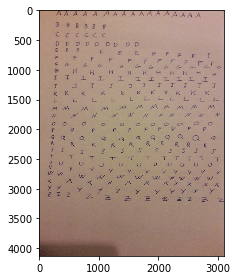

In [3]:
gray_image = skio.imread(os.path.join("input", "characters_sheet.jpg"), as_gray=True)
gray_image = sktr.rotate(gray_image, -90., resize=True)
skio.imshow(gray_image)
skio.show()
#plt.show()

In [4]:
#skio.call_plugin("imshow", "matplotlib")
skio.find_available_plugins()

{'fits': ['imread', 'imread_collection'],
 'freeimage': ['imread', 'imsave', 'imread_collection'],
 'gdal': ['imread', 'imread_collection'],
 'gtk': ['imshow'],
 'imageio': ['imread', 'imsave', 'imread_collection'],
 'imread': ['imread', 'imsave', 'imread_collection'],
 'matplotlib': ['imshow', 'imread', 'imshow_collection', 'imread_collection'],
 'pil': ['imread', 'imsave', 'imread_collection'],
 'qt': ['imshow', 'imsave', 'imread', 'imread_collection'],
 'simpleitk': ['imread', 'imsave', 'imread_collection'],
 'test': ['imsave',
  'imshow',
  'imread',
  'imread_collection',
  'imshow_collection'],
 'tifffile': ['imread', 'imsave', 'imread_collection']}

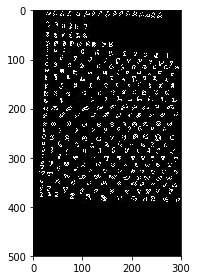

In [5]:
image_canny = skio.imread(os.path.join(src_folder, "canny.jpg"))
image_canny = sktr.rotate(image_canny, -90., resize=True)
skio.imshow(image_canny)
skio.show()

C:\Users\clement_besnier\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


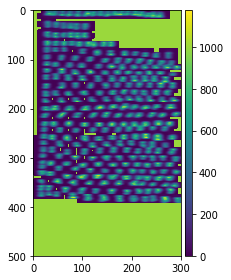

In [6]:
def calculate_energy(image):
    # size = 11
    energy = np.zeros(image.shape)
    size_max = 25
    for size in range(3, size_max, 4):
        kernel = np.zeros((size, size))
        kernel[int(size/2)-2:int(size/2)+2, :] = 1
        energy += (size_max-size)*scipy.ndimage.filters.convolve(image, kernel)
    energy = 1000*(energy == np.zeros(image.shape)) + energy
    return energy

energy = calculate_energy(image_canny)
skio.imshow(energy)
skio.show()

In [7]:
a = np.sum(energy, axis=1)/500
a

array([ 130.24901961,  172.72901961,  212.64588235,  250.07913725,
        283.03317647,  291.09974902,  297.44569412,  323.75871373,
        352.66230588,  380.36966275,  359.91984314,  321.20591373,
        246.24103529,  172.53463529,  134.31319216,   98.17888627,
         76.25529412,   62.4534902 ,  542.60020392,  542.44174118,
        542.39239216,  544.7344    ,  373.45129412,  382.81722353,
        393.70177255,  403.24177255,  416.16509804,  431.64894118,
        437.53843137,  442.5422902 ,  443.24519216,  437.4262902 ,
        442.65661176,  440.6984    ,  453.78009412,  446.75490196,
        434.50592941,  421.46872157,  394.60404706,  382.94312157,
        371.28892549,  371.66588235,  391.22607059,  398.26059608,
        420.24950588,  443.39694118,  445.28580392,  465.70909804,
        458.41709804,  454.13261176,  455.79957647,  458.42767059,
        467.24116078,  469.8158902 ,  456.59220392,  426.04903529,
        402.15927843,  383.24247843,  389.91091765,  389.57582

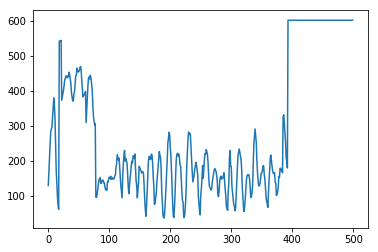

In [8]:
plt.plot(a)

In [9]:
threshold = 125
under_threshold = a < np.ones(a.shape)*threshold
n_lines = np.sum(under_threshold)
under_threshold, n_lines

(array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True,  True,  True,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True,  True,  True,
         True, False, False, False, False, False, False, False, False,
        False, False, False, False,  True,  True,  True, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False,  True,  True, False, False, False, False,
      

In [10]:
#from scipy.signal import argrelextrema


np.sum(np.r_[True, a[1:] < a[:-1]] & np.r_[a[:-1] < a[1:], True])


59

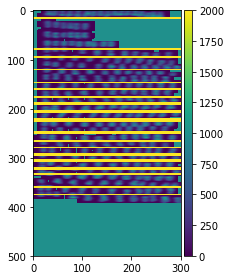

In [19]:
i = 0
for under in under_threshold:
    if under:
        rr, cc = skdr.draw.line(i, 0, i, energy.shape[1]-1)
        energy[rr, cc] = 2000
    i += 1
skio.imshow(energy)
skio.show()

### Run-length Smearing

In [30]:
def fill_lines(image, threshold, gap_tolerance):
    image = image < np.ones(image.shape)*threshold
    lines = []
    for line in range(image.shape[0]):
        color = image[line, 0]
        index = 0
        lines.append([[color, 1],])
        for column in range(1, image.shape[1]):
            if image[line, column] == color:
                lines[line][index][1] += 1
            else:
                if lines[line][index][1] > gap_tolerance:
                    color = image[line, column]
                    #print(line, index)
                    lines[line].append([color, 1])
                    index += 1
                else:
                    lines[line][index][1] += 1
                
    return lines
fill_lines(image_canny, 0.5, 30)

[[[True, 301]],
 [[True, 31], [False, 31], [True, 47], [False, 31], [True, 161]],
 [[True, 34],
  [False, 31],
  [True, 44],
  [False, 31],
  [True, 39],
  [False, 31],
  [True, 91]],
 [[True, 32],
  [False, 31],
  [True, 45],
  [False, 32],
  [True, 39],
  [False, 31],
  [True, 91]],
 [[True, 35],
  [False, 31],
  [True, 42],
  [False, 32],
  [True, 38],
  [False, 33],
  [True, 90]],
 [[True, 35],
  [False, 31],
  [True, 41],
  [False, 31],
  [True, 39],
  [False, 31],
  [True, 36],
  [False, 31],
  [True, 26]],
 [[True, 31],
  [False, 31],
  [True, 31],
  [False, 31],
  [True, 39],
  [False, 31],
  [True, 39],
  [False, 31],
  [True, 37]],
 [[True, 33],
  [False, 31],
  [True, 42],
  [False, 31],
  [True, 31],
  [False, 31],
  [True, 34],
  [False, 31],
  [True, 37]],
 [[True, 35],
  [False, 31],
  [True, 39],
  [False, 31],
  [True, 33],
  [False, 31],
  [True, 32],
  [False, 31],
  [True, 38]],
 [[True, 31],
  [False, 32],
  [True, 31],
  [False, 31],
  [True, 37],
  [False, 32],
 

In [ ]:
def fill_columns(image, gap_tolerance):

### X-Y Cut

### Docstrum

### Whitespace Analysis

### Voronoi

## Sources

[TEXT LINE EXTRACTION USING SEAM CARVING](https://etd.ohiolink.edu/!etd.send_file?accession=akron1428077337&disposition=inline) by Christopher Stoll



**Author**: Clément Besnier, [@clemsciences](https://twitter.com/clemsciences) and  [my personal website](https://clementbesnier.pythonanywhere.com)
    